In [1]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint
from ray import tune
from ray.tune import CLIReporter
from ray import tune
from ray import train
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection
from darts.dataprocessing.transformers import Scaler
from darts.models import DLinearModel
from darts import TimeSeries, concatenate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import tensorboard
import os

In [2]:
class LossLoggingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.val_losses = []  # To store validation losses
        self.train_losses = []  # To store training losses

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics["val_loss"].item()
        self.val_losses.append(val_loss)
        print(f"Epoch {trainer.current_epoch}: val_loss={val_loss}")
        train.report({"loss": val_loss})

    def on_train_epoch_end(self, trainer, pl_module, unused=None):  # unused parameter for compatibility
        # Assuming you have a metric named "train_loss" logged
        if "train_loss" in trainer.callback_metrics:
            train_loss = trainer.callback_metrics["train_loss"].item()
            self.train_losses.append(train_loss)
            print(f"Epoch {trainer.current_epoch}: train_loss={train_loss}")

In [72]:
df = pd.read_csv('EDvisitfileL.csv', encoding='ISO-8859-1')

# 确保'date'列是DateTime类型
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.rename(columns={'No_Linkou': 'No'})

# 分割数据集为训练集、验证集和测试集（假设您已经根据时间排序）
#train_proportion = 0.5
#val_proportion = 0.3

# Calculate the split indices
total_length = len(df)
train_end = 4374
val_end = 4741
#val_end = train_end + int(total_length * val_proportion)

# Split the DataFrame
train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# 步骤2: 使用MinMaxScaler缩放数据
# 定义并拟合scaler
scaler = MinMaxScaler()
scaler.fit(train_df[['No']])  # 只用训练数据拟合scaler

# 缩放训练集和验证集
train_df.loc[:, 'No_scaled'] = scaler.transform(train_df[['No']])
val_df.loc[:, 'No_scaled'] = scaler.transform(val_df[['No']])
test_df.loc[:, 'No_scaled'] = scaler.transform(test_df[['No']])  # 用相同的scaler转换测试集以避免数据泄露

train_series = TimeSeries.from_dataframe(train_df, value_cols='No_scaled' )
val_series = TimeSeries.from_dataframe(val_df, value_cols='No_scaled' )
test_series = TimeSeries.from_dataframe(test_df, value_cols='No_scaled' )

# 原始数据转换为TimeSeries对象，如果需要
train_series_origin = TimeSeries.from_dataframe(train_df, value_cols='No'  )
val_series_origin = TimeSeries.from_dataframe(val_df, value_cols='No' )
test_series_origin = TimeSeries.from_dataframe(test_df, value_cols='No' )

# 选择需要的列创建多变量时间序列(都是one hot coding)
columns = ['Dayoff', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun',  'YearScaled',
           'MonthScaled', 'Dayscaled', 'NewYear', '3Lock','Screening','COV19ThreadScaled']
'''
columns = ['Dayoff', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun',  'YearScaled',
           'MonthScaled', 'Dayscaled', 'NewYear', '3Lock', 'ConfirmedCases_scaled', 'Screening']
'''
df_multivariate = df[columns]
# 将DataFrame转换为多变量时间序列
ED_covariates = TimeSeries.from_dataframe(df_multivariate )

C:\Users\ian11\AppData\Local\Temp\ipykernel_7988\292504794.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'No_scaled'] = scaler.transform(train_df[['No']])
C:\Users\ian11\AppData\Local\Temp\ipykernel_7988\292504794.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[:, 'No_scaled'] = scaler.transform(val_df[['No']])
C:\Users\ian11\AppData\Local\Temp\ipykernel_7988\292504794.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 129 K 
5 | linear_trend    | Linear           | 129 K 
-----------------------------------------------------
259 K     Trainable params
0         Non-trainable params
259 K     Total params
1.038     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0: val_loss=0.10132969835547838


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: val_loss=0.0954600331084169
Epoch 0: train_loss=0.006726279889768813


Validation: 0it [00:00, ?it/s]

Epoch 1: val_loss=0.09043643332241555
Epoch 1: train_loss=0.006384132026915354


Validation: 0it [00:00, ?it/s]

Epoch 2: val_loss=0.08962135847253425
Epoch 2: train_loss=0.007409601254625728


Validation: 0it [00:00, ?it/s]

Epoch 3: val_loss=0.08754752017870664
Epoch 3: train_loss=0.00716615942822201


Validation: 0it [00:00, ?it/s]

Epoch 4: val_loss=0.08967046081580143
Epoch 4: train_loss=0.00993303981705605


Validation: 0it [00:00, ?it/s]

Epoch 5: val_loss=0.08737889384307655
Epoch 5: train_loss=0.007845415073912027


Validation: 0it [00:00, ?it/s]

Epoch 6: val_loss=0.0867073853451259
Epoch 6: train_loss=0.007560603342291075


Validation: 0it [00:00, ?it/s]

Epoch 7: val_loss=0.08596866553847188
Epoch 7: train_loss=0.005320986210060723


Validation: 0it [00:00, ?it/s]

Epoch 8: val_loss=0.08671551454719119
Epoch 8: train_loss=0.008558804232754897


Validation: 0it [00:00, ?it/s]

Epoch 9: val_loss=0.08783150488215127
Epoch 9: train_loss=0.007630341858632054


Validation: 0it [00:00, ?it/s]

Epoch 10: val_loss=0.08766521949243873
Epoch 10: train_loss=0.007013225654578421


Validation: 0it [00:00, ?it/s]

Epoch 11: val_loss=0.08536191473441387
Epoch 11: train_loss=0.007474193188353019


Validation: 0it [00:00, ?it/s]

Epoch 12: val_loss=0.08344076529272931
Epoch 12: train_loss=0.008617646854055689


Validation: 0it [00:00, ?it/s]

Epoch 13: val_loss=0.08921001330214602
Epoch 13: train_loss=0.007895871862808242


Validation: 0it [00:00, ?it/s]

Epoch 14: val_loss=0.0858887315339095
Epoch 14: train_loss=0.007893826190927556


Validation: 0it [00:00, ?it/s]

Epoch 15: val_loss=0.08306064225156617
Epoch 15: train_loss=0.005601638190364039


Validation: 0it [00:00, ?it/s]

Epoch 16: val_loss=0.08691064726122033
Epoch 16: train_loss=0.0076430338466109285


Validation: 0it [00:00, ?it/s]

Epoch 17: val_loss=0.08392456211126763
Epoch 17: train_loss=0.007225018173710503


Validation: 0it [00:00, ?it/s]

Epoch 18: val_loss=0.08598664098108454
Epoch 18: train_loss=0.008962661887671265


Validation: 0it [00:00, ?it/s]

Epoch 19: val_loss=0.08593578902389148
Epoch 19: train_loss=0.006620298310553996


Validation: 0it [00:00, ?it/s]

Epoch 20: val_loss=0.08335476779201907
Epoch 20: train_loss=0.0063616151322162555


Validation: 0it [00:00, ?it/s]

Epoch 21: val_loss=0.08752307321728
Epoch 21: train_loss=0.00889392553908412


Validation: 0it [00:00, ?it/s]

Epoch 22: val_loss=0.08312572028411315
Epoch 22: train_loss=0.006985305710907395


Validation: 0it [00:00, ?it/s]

Epoch 23: val_loss=0.08462934424043748
Epoch 23: train_loss=0.00788719765113218


Validation: 0it [00:00, ?it/s]

Epoch 24: val_loss=0.08679834734387198
Epoch 24: train_loss=0.005440357870525768


Validation: 0it [00:00, ?it/s]

Epoch 25: val_loss=0.08470330166459838
Epoch 25: train_loss=0.008131103940741463


Validation: 0it [00:00, ?it/s]

Epoch 26: val_loss=0.08440245152948198
Epoch 26: train_loss=0.006932388309571271


Validation: 0it [00:00, ?it/s]

Epoch 27: val_loss=0.09049422647079051
Epoch 27: train_loss=0.007718833508736563


Validation: 0it [00:00, ?it/s]

Epoch 28: val_loss=0.08455978028245714
Epoch 28: train_loss=0.007887253909873538


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: val_loss=0.08516537834586162
Epoch 29: train_loss=0.006296331921624384


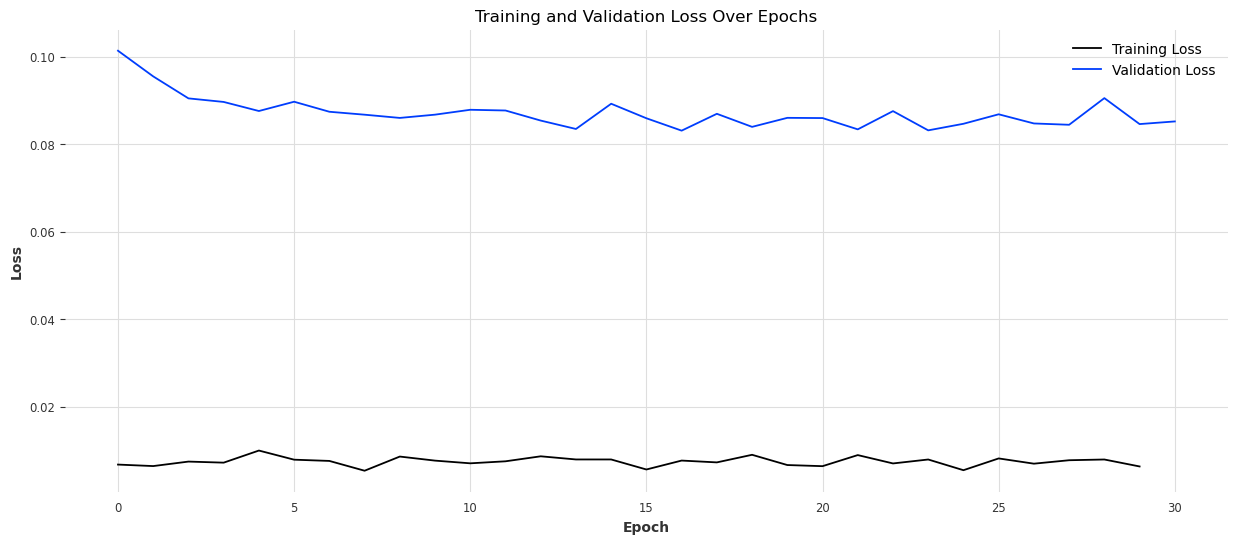

In [73]:
loss_logging_callback = LossLoggingCallback()

'''
checkpoint_callback = ModelCheckpoint(
    filename='_model_{epoch:02d}',
    monitor='val_loss',
    save_top_k=-1,
    every_n_epochs=5,
    dirpath='/darts_logs/_model.pth.tar'# Save every 5 epochs
)
'''

torch_metrics = MetricCollection([MeanAbsolutePercentageError(), MeanAbsoluteError()])

model = DLinearModel(
    input_chunk_length=90,
    output_chunk_length=90,
    batch_size=64,
    kernel_size=20,
    model_name="DLinearFineL2021(1)",
    lr_scheduler_kwargs=0.00001,
    save_checkpoints=True,
    pl_trainer_kwargs = {
    "callbacks": [loss_logging_callback]},)

# After defining the model, proceed with the training as before
models = {
    "DLinear": model,
}

model.fit(
    epochs=30,
    series=[train_series],
    past_covariates=[ED_covariates],
    val_series=[val_series],
    val_past_covariates=[ED_covariates]
    #past_covariates=[WeekdayTrain, DayoffTrain]
    #enable_checkpointing=True,
)

# Step 3: Plotting the losses after training is completed
plt.figure(figsize=(15, 6))

# Plot training losses
plt.plot(loss_logging_callback.train_losses, label="Training Loss")

# Plot validation losses
plt.plot(loss_logging_callback.val_losses, label="Validation Loss")

plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
from darts.metrics import mae, mse, mape
import matplotlib.pyplot as plt

In [74]:
model = DLinearModel.load_from_checkpoint('DLinearFineL2021(1)')
hyperparameters = model.model_params
print(hyperparameters)
#model_loaded = model.load_weights('darts_logs/NHiTSFine2019(50)/checkpoints/last-epoch=49', load_encoders=False, skip_checks=True)
#model_loaded = model.load_weights('darts_logs\NHiTSFine2019(30)\checkpoints', load_encoders=False, skip_checks=True)
Model_prediction = model.predict(731, series=train_series, past_covariates=ED_covariates
                                )
# invert scale, 資料格式轉換
Model_prediction_df = Model_prediction.pd_dataframe()
Model_prediction_df_inverse = scaler.inverse_transform(Model_prediction_df)
Model_prediction_df_inverse = pd.DataFrame(Model_prediction_df_inverse,
                      index=Model_prediction_df.index,
                      columns=Model_prediction_df.columns)

# 計算誤差
Model_prediction_ts_inverse = TimeSeries.from_dataframe(Model_prediction_df_inverse)
Model_mae = mae(test_series_origin, Model_prediction_ts_inverse)
Model_mse = mse(test_series_origin, Model_prediction_ts_inverse)
Model_mape = mape(test_series_origin, Model_prediction_ts_inverse)

print(Model_mae, Model_mse, Model_mape)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


OrderedDict([('shared_weights', False), ('kernel_size', 20), ('const_init', True), ('use_static_covariates', True), ('input_chunk_length', 90), ('output_chunk_length', 90), ('batch_size', 64), ('model_name', 'DLinearFineL2021(1)'), ('lr_scheduler_kwargs', 1e-05), ('save_checkpoints', True), ('pl_trainer_kwargs', {'callbacks': [<__main__.LossLoggingCallback object at 0x00000147741DC3D0>]})])


Predicting: 0it [00:00, ?it/s]

167.3144050005705 39524.34720583469 35.530432434630214


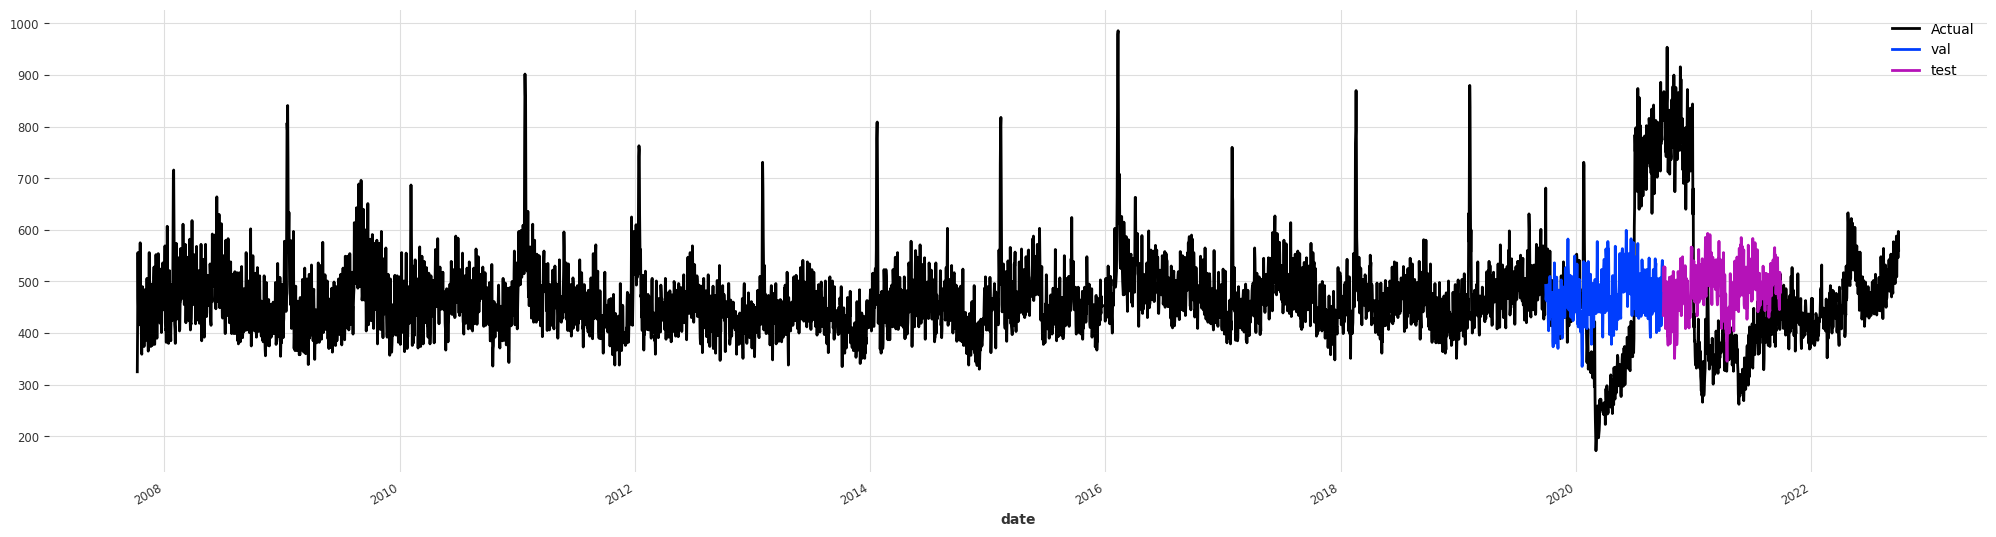

In [75]:
series_origin_complete = TimeSeries.from_dataframe(df, value_cols=['No'])

Model_prediction_ts_inverse_val, Model_prediction_ts_inverse_test = Model_prediction_ts_inverse.split_before(0.5)

# 绘制图表
plt.figure(figsize=(25, 6))
series_origin_complete.plot(label='Actual')

# 使用之前转换和逆缩放后的预测结果
Model_prediction_ts_inverse_val.plot(label='val')
Model_prediction_ts_inverse_test.plot(label='test')

plt.legend()
plt.show()

In [69]:
Model_prediction_df_inverse.to_csv(path_or_buf='timeseries/TrainingResult/DLineartransfer/Linkou/forecast2022.csv')